In [1]:
import tensorflow as tf
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (20, 20) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

In [2]:
from util.data_loader import *
dataset = data_loader('data/kitti_full.npy', 'data/kitti_full_metadata.json')

Data loaded! Took 2.80 seconds
Data Shape (47889, 128, 384, 3)
train: 45733   test: 2005


In [3]:
def conv_block(inputs, conv_filter, conv_kernel):
    conv1 = tf.layers.conv2d(inputs, 
                             conv_filter, 
                             conv_kernel,
                             padding='same', 
                             activation=parametric_relu)
    conv2 = tf.layers.conv2d(conv1, 
                             conv_filter, 
                             conv_kernel,
                             padding='same', 
                             activation=parametric_relu)
    conv3 = tf.layers.conv2d(conv2, 
                             conv_filter, 
                             conv_kernel,
                             padding='same', 
                             activation=parametric_relu)
    pooled = tf.layers.max_pooling2d(conv3, (2,2), (2,2))
    return pooled
def dconv_block(inputs, dconv_filter, dconv_kernel, dconv_strides, conv_input = None):
    if conv_input is not None:
        inputs = tf.concat([inputs, conv_input], 3)
    dconv = tf.layers.conv2d_transpose(inputs,
                                       dconv_filter,
                                       dconv_kernel,
                                       dconv_strides,
                                       padding='same',
                                       activation=parametric_relu)
    conv1 = tf.layers.conv2d(dconv, 
                             dconv_filter, 
                             (3,3),
                             padding='same', 
                             activation=parametric_relu)
    conv2 = tf.layers.conv2d(conv1, 
                             dconv_filter, 
                             (3,3),
                             padding='same', 
                             activation=parametric_relu)
    return conv2

In [4]:
def parametric_relu(x):
    with tf.variable_scope("PReLu") as scope:
        alpha = tf.get_variable('alpha', [1],
                           initializer=tf.constant_initializer(0.0),
                            dtype=tf.float32)
        h = tf.maximum(alpha * tf.ones_like(x), x)
    return h

In [5]:
tf.reset_default_graph()
def deep_CNN_model(X,y):
    conv_block1 = conv_block(X, 48, (3,3))
    conv_block2 = conv_block(conv_block1, 48, (3,3))
    conv_block3 = conv_block(conv_block2, 96, (3,3))
    conv_block4 = conv_block(conv_block3, 96, (3,3))
    conv_block5 = conv_block(conv_block4, 96, (3,3))
    dconv_block5 = dconv_block(conv_block5, 96, (4,4), (2,2))
    dconv_block4 = dconv_block(dconv_block5, 96, (4,4), (2,2), conv_block4)
    dconv_block3 = dconv_block(dconv_block4, 96, (4,4), (2,2), conv_block3)
    dconv_block2 = dconv_block(dconv_block3, 48, (4,4), (2,2), conv_block2)
    dconv_block1 = dconv_block(dconv_block2, 3, (4,4), (2,2))
    y_out = dconv_block1
    return y_out

X = tf.placeholder(tf.float32, [None, 128, 384, 6])
y = tf.placeholder(tf.float32, [None, 128, 384, 3])

learning_rate = 1e-3
y_out = deep_CNN_model(X,y)

## mean_loss = tf.reduce_mean(tf.nn.l2_loss(y_out - y))
# Charbonnier Loss
epsilon = 0.1
batch_loss = tf.reduce_sum(tf.sqrt((y_out - y) ** 2 + epsilon ** 2))
optimizer = tf.train.AdamOptimizer(learning_rate)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(batch_loss)

pass

2859it [42:10,  1.04it/s, loss=1.002e+07]
2859it [42:05,  1.41it/s, loss=4.421e+06]

epoch: 1 Mean Loss 3.769e+07 Time: 2530.4seconds
epoch: 2 Mean Loss 2.080e+07 Time: 2525.7seconds


2859it [42:01,  1.42it/s, loss=3.740e+06]


epoch: 3 Mean Loss 1.534e+07 Time: 2521.2seconds


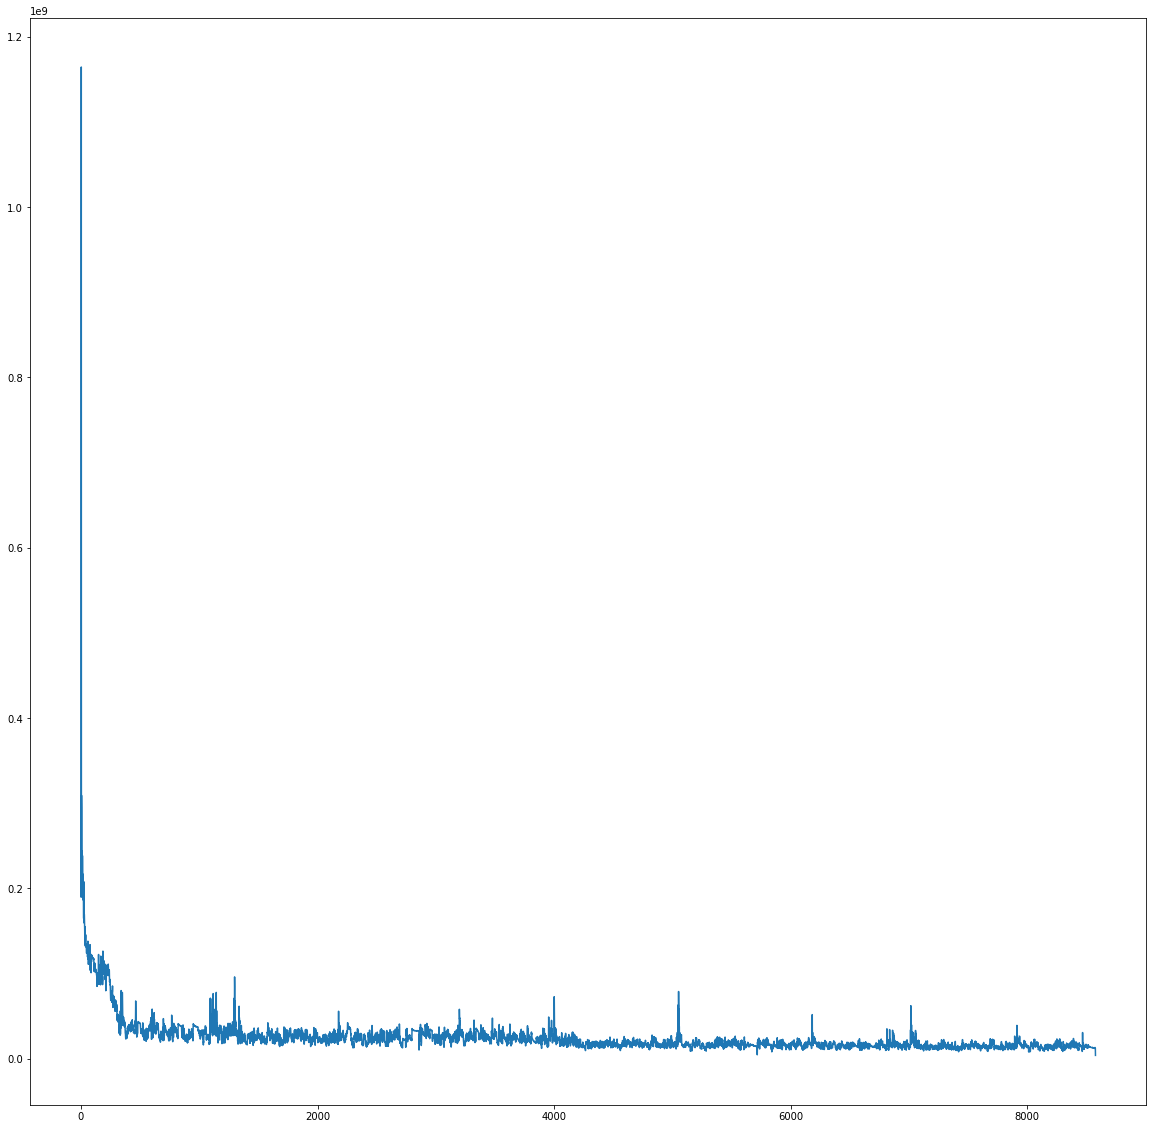

In [6]:
num_epochs = 3
sess =  tf.Session()
sess.run(tf.global_variables_initializer())
variables = [batch_loss,train_step]
history = []
for e in range(num_epochs):
    batch_num = 0
    epoch_loss = []
    epoch_start = time.time()
    pbar = tqdm(dataset.get_minibatches(), total = int(45733/16))
    for batch_x, batch_y in pbar:
        loss, _ = sess.run(variables,feed_dict={X: batch_x, y: batch_y})
        pbar.set_postfix(loss = "{:.3e}".format(loss))
        pbar.update()
        batch_num += 1
        history.append(loss)
        epoch_loss.append(loss)
    epoch_end = time.time()
    print('epoch: {0} Mean Loss {1:.3e} Time: {2:.1f}seconds'.format(e+1, sum(epoch_loss)/len(epoch_loss), epoch_end - epoch_start))
plt.plot(history)

In [7]:
batch_x, batch_y = dataset.get_batch()
feed_dict = {X: batch_x, y: batch_y}
pred, loss = sess.run([y_out, batch_loss],feed_dict=feed_dict)

In [8]:
loss

7116572.0

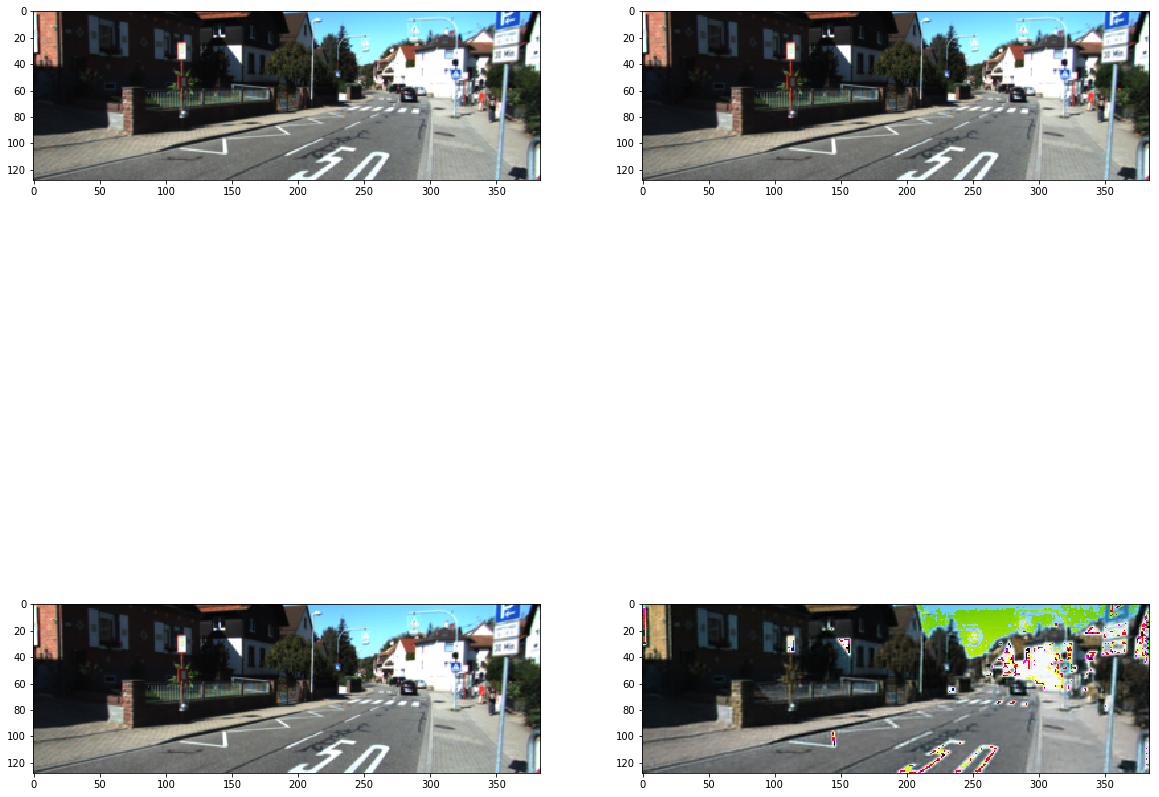

In [20]:
test_ind = 2
plt.subplot(221)
plt.imshow((batch_x[test_ind,:,:,:3]).astype('uint8'))
plt.subplot(222)
plt.imshow((batch_x[test_ind,:,:,3:]).astype('uint8'))
plt.subplot(223)
plt.imshow((batch_y[test_ind,:,:,:]).astype('uint8'))
plt.subplot(224)
plt.imshow((pred[test_ind,:,:,:]).astype('uint8'))

In [26]:
diff = (batch_x[test_ind,:,:,0:3] - batch_x[test_ind,:,:,3:6])
np.sum(np.sqrt(diff ** 2))

0.0

In [35]:
batch_x

array([[[[255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255]],

        [[255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255]],

        [[255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255],
         ..., 
         [255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255]],

        ..., 
        [[ 59,  69,  81,  59,  69,  81],
         [ 43,  54,  64,  43,  54,  64],
         [ 35,  43,  51,  35,  43,  51],
         ..., 
         [ 93,  92,  90,  93,  92,  90],
         [ 95,  93

In [22]:
diff = (batch_y[test_ind,:,:,:] - pred[test_ind,:,:,:])
np.sum(np.sqrt(diff ** 2 + epsilon * np.ones_like(diff)))

994143.81

In [23]:
batch_x[test_ind,:,:,:].shape

(128, 384, 6)

In [29]:
dataset.train_x_start_index[0:5]

[39951, 39952, 39953, 39954, 39955]

In [30]:
dataset.train_x_end_index[0:5]

[39952, 39953, 39954, 39955, 39956]

In [32]:
dataset.train_y_index[0:5]

[39951, 39952, 39953, 39954, 39955]

In [34]:
dataset.data[39951, :, :, :] - dataset.data[39952, :, :, :]

array([[[ 38,  29,  53],
        [ 73,  68,  91],
        [ 78,  90,  91],
        ..., 
        [198, 191, 142],
        [228, 234, 192],
        [  1,  22, 240]],

       [[ 35,  33,  53],
        [ 68,  68,  84],
        [ 72,  86,  87],
        ..., 
        [189, 170, 128],
        [207, 205, 162],
        [236, 248, 203]],

       [[ 35,  29,  56],
        [ 62,  62,  88],
        [ 74,  84,  89],
        ..., 
        [201, 187, 148],
        [213, 226, 194],
        [234, 249, 221]],

       ..., 
       [[  2,   5,   5],
        [  3,   5,   5],
        [  3,   5,   7],
        ..., 
        [ 17,   8, 252],
        [ 12,   4, 254],
        [ 15,  17,   9]],

       [[  6,   6,   5],
        [  7,   5,   7],
        [  5,   5,   6],
        ..., 
        [ 23,  22,  19],
        [ 22,  25,  21],
        [ 27,  42,  31]],

       [[  4,   5,   7],
        [  3,   3,   5],
        [  3,   4,   3],
        ..., 
        [ 35,  47,  54],
        [ 35,  49,  58],
        [ 42,  51,